In [1]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


In [2]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 18.6 MB/s 
     |████████████████████████████████| 453 kB 6.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
train_data = pd.read_excel('/content/감성대화말뭉치(최종데이터)_Training.xlsx')
test_data = pd.read_excel('/content/감성대화말뭉치(최종데이터)_Validation.xlsx')

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 40879


In [8]:
train_data[:5]

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


# 사람 문장 3, 4를 제외한이유
- 대부분의 감정은 사람문장 1, 2 에서 드러나는 경우가많다고 판단
- 문장 3, 4 에는 Nan값이많아 전처리중에 문제가 발생

# 사람문장1, 사람문장2, 를 합쳐도 될거같다고 생각해서 일단은 합쳐봄

In [9]:
train_data1 = train_data.drop(['번호','연령','성별','상황키워드','신체질환','사람문장2','사람문장3','사람문장4','시스템응답1','시스템응답2','시스템응답3','시스템응답4'], axis=1)
train_data2 = train_data.drop(['번호','연령','성별','상황키워드','신체질환','사람문장1','사람문장3','사람문장4','시스템응답1','시스템응답2','시스템응답3','시스템응답4'], axis=1)

In [10]:
train_data1[:5]

,감정_대분류,감정_소분류,사람문장1
0,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.
1,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.


In [11]:
train_data2[:5]

,감정_대분류,감정_소분류,사람문장2
0,기쁨,신이 난,아 지금 정말 신이 나.
1,불안,스트레스 받는,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.
2,당황,당황,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.
3,기쁨,신이 난,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...
4,기쁨,안도,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.


In [12]:
train_data2.rename(columns={'사람문장2':'사람문장1'},inplace=True)
train_data2[:5]

,감정_대분류,감정_소분류,사람문장1
0,기쁨,신이 난,아 지금 정말 신이 나.
1,불안,스트레스 받는,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.
2,당황,당황,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.
3,기쁨,신이 난,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...
4,기쁨,안도,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.


In [13]:
train_data = train_data1.append(train_data2)
train_data[:5]

,감정_대분류,감정_소분류,사람문장1
0,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.
1,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.


In [14]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 5130


In [15]:
test_data1 = test_data.drop(['번호','연령','성별','상황키워드','신체질환','사람문장2','사람문장3','사람문장4','시스템응답1','시스템응답2','시스템응답3','시스템응답4'], axis=1)
test_data2 = test_data.drop(['번호','연령','성별','상황키워드','신체질환','사람문장1','사람문장3','사람문장4','시스템응답1','시스템응답2','시스템응답3','시스템응답4'], axis=1)

In [16]:
test_data2.rename(columns={'사람문장2':'사람문장1'},inplace=True)
test_data2[:5]

,감정_대분류,감정_소분류,사람문장1
0,분노,툴툴대는,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...
1,슬픔,비통한,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...
2,불안,조심스러운,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.
3,당황,죄책감의,곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아.
4,분노,노여워하는,어떻게 그럴 수가 있지? 너무 화가 나.


In [17]:
test_data = test_data1.append(test_data2)
test_data[:5]

,감정_대분류,감정_소분류,사람문장1
0,분노,툴툴대는,요즘 부모님과 많이 부딪혀.
1,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.
2,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.
3,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.
4,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.


In [18]:
test_data[:5]

,감정_대분류,감정_소분류,사람문장1
0,분노,툴툴대는,요즘 부모님과 많이 부딪혀.
1,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.
2,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.
3,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.
4,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.


In [19]:
train_data['label'] = 0
train_data[:5]

,감정_대분류,감정_소분류,사람문장1,label
0,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0
2,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,0
3,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,0


In [20]:
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [21]:
train_data['감정_대분류'][3]

'기쁨'

In [22]:
for i in range(len(train_data)):
  if train_data['감정_대분류'][i] == '기쁨' or train_data['감정_대분류'][i] == '기쁨 ':
    train_data['label'][i] = 1
  else:
    train_data['label'][i] = 0

train_data[-5:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,감정_대분류,감정_소분류,사람문장1,label
81753,불안,혼란스러운,나한테 아예 떠넘길 거 같은데 친구한테 얘기해볼까 고민 중이야.,0
81754,기쁨,안도,결과가 좋게 나와서 다행이야,1
81755,슬픔,우울한,내 재능이 남들보다 월등한 거는 아니라면서 취업해서 안정적으로 살았으면 좋겠다고 하셔.,0
81756,기쁨,감사하는,덕분에 건강도 챙길 수 있고 너무 좋아. 안마기도 있던데 내일은 운동하고 안마기도 ...,1
81757,불안,스트레스 받는,카페에 가서 대화하거나 같이 술 마시면서 이야기했던 것 같아.,0


In [23]:
test_data['label'] = 0
test_data[:5]

,감정_대분류,감정_소분류,사람문장1,label
0,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,0
1,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,0
2,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,0
3,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,0
4,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,0


In [24]:
for i in range(len(test_data)):
  if train_data['감정_대분류'][i] == '기쁨' or train_data['감정_대분류'][i] == '기쁨 ':
    test_data['label'][i] = 1
  else:
    test_data['label'][i] = 0

test_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,감정_대분류,감정_소분류,사람문장1,label
0,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,1
1,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,0
2,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,0
3,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,1
4,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,1


In [25]:
test_data[-5:]

,감정_대분류,감정_소분류,사람문장1,label
10255,기쁨,느긋,그래서 마음의 안정을 가질 수 있었던 것 같아.,0
10256,불안,회의적인,이대로 혹시 더 심해져서 죽게 되는 건 아닐까?,0
10257,분노,좌절한,내가 게을러서 다른 방법을 아직 생각하진 못했어. 댄스 동호회는 좀 괜찮은 것 같은...,0
10258,분노,안달하는,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.,0
10259,분노,짜증내는,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아. 안부전화라도 해주면 좋을 텐데.,0


----

# 일단저장해보자

In [28]:
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

---

In [28]:
print(train_data.isnull().sum())

감정_대분류    0
감정_소분류    0
사람문장1     0
label     0
dtype: int64


In [29]:
train_data.drop_duplicates(subset=['사람문장1'], inplace=True)

In [30]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 78288


In [31]:
test_data.drop_duplicates(subset=['사람문장1'], inplace=True)

In [32]:
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 10199


In [33]:
print(len(train_data['사람문장1']))
print(len(train_data['label']))

78288
78288


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


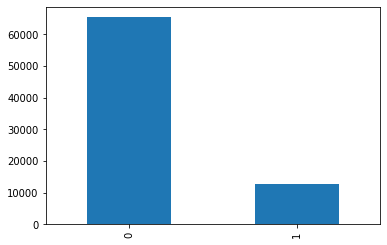

In [34]:
train_data['label'].value_counts().plot(kind = 'bar')

In [35]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  65421
1      1  12867


# 당황 카테고리 지우기

In [83]:
train_data = train_data[train_data.감정_대분류 != '당황']

In [84]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 32726


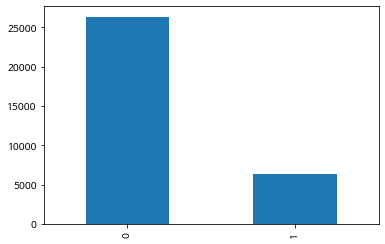

In [85]:
train_data['label'].value_counts().plot(kind = 'bar')

In [86]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  26347
1      1   6379


In [87]:
print(train_data.isnull().values.any())

False


---

In [36]:
# 한글과 공백을 제외하고 모두 제거
train_data['사람문장1'] = train_data['사람문장1'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [37]:
train_data['사람문장1'] = train_data['사람문장1'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['사람문장1'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


감정_대분류    0
감정_소분류    0
사람문장1     0
label     0
dtype: int64


In [38]:
print(len(train_data['사람문장1']))
print(len(train_data['label']))

78288
78288


In [39]:
train_data[:5]

,감정_대분류,감정_소분류,사람문장1,label
0,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나,1
1,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,0
2,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,0
3,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,1
4,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,1


In [40]:
test_data['사람문장1'] = test_data['사람문장1'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_data['사람문장1'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

감정_대분류    0
감정_소분류    0
사람문장1     0
label     0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [41]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','이']

In [42]:
okt = Okt()
okt.morphs('은행 대출이 막혀서 생활비를 구할 수가 없어 이제 어떻게 살아야 하나 막막해', stem = True)

['은행',
 '대출',
 '이',
 '막히다',
 '생활비',
 '를',
 '구',
 '하다',
 '수가',
 '없다',
 '이제',
 '어떻다',
 '살다',
 '하나',
 '막막하다']

In [43]:
X_train = []
for sentence in tqdm(train_data['사람문장1']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 78288/78288 [01:53<00:00, 687.80it/s]


In [44]:
print(len(train_data['사람문장1']))
print(len(train_data['label']))

78288
78288


In [45]:
X_test = []
for sentence in tqdm(test_data['사람문장1']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 10199/10199 [00:14<00:00, 695.64it/s]


In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [47]:
print(tokenizer.word_index)

{'을': 1, '내': 2, '나': 3, '너무': 4, '있다': 5, '것': 6, '같다': 7, '친구': 8, '없다': 9, '보다': 10, '안': 11, '않다': 12, '되다': 13, '좋다': 14, '못': 15, '에서': 16, '이야': 17, '말': 18, '싶다': 19, '만': 20, '사람': 21, '들다': 22, '받다': 23, '생각': 24, '모르다': 25, '에게': 26, '게': 27, '돼다': 28, '더': 29, '돈': 30, '정말': 31, '일': 32, '자다': 33, '수': 34, '나다': 35, '걱정': 36, '하고': 37, '그렇다': 38, '회사': 39, '다': 40, '로': 41, '많이': 42, '힘들다': 43, '한테': 44, '때': 45, '고': 46, '가다': 47, '어떻다': 48, '나르다': 49, '거': 50, '요즘': 51, '아니다': 52, '마음': 53, '때문': 54, '오늘': 55, '아내': 56, '그': 57, '해': 58, '스럽다': 59, '남편': 60, '응': 61, '결혼': 62, '우리': 63, '기분': 64, '많다': 65, '야': 66, '화가': 67, '아프다': 68, '이번': 69, '적': 70, '먹다': 71, '오다': 72, '슬프다': 73, '집': 74, '이제': 75, '준비': 76, '나이': 77, '나오다': 78, '인데': 79, '왜': 80, '주다': 81, '직장': 82, '라고': 83, '아들': 84, '일이': 85, '지금': 86, '맞다': 87, '엄마': 88, '다른': 89, '건강': 90, '가족': 91, '난': 92, '불안하다': 93, '되어다': 94, '랑': 95, '자식': 96, '부모님': 97, '걸': 98, '자꾸': 99, '까지': 100, '병원': 101, '날': 102, 

In [48]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12441
등장 빈도가 3번 이하인 희귀 단어의 수: 6073
단어 집합에서 희귀 단어의 비율: 48.81440398681778
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1453731935399194


등장 빈도가 threshold 값인 4회 미만. 즉, 3회 이하인 단어들은 단어 집합에서 무려 절반 을 차지. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 2.18%밖에 되지 않음. 등장 빈도가 3회 이하인 단어들은 자연어 처리에서 별로 중요하지 않다고 생각. 그래서 이 단어들은 정수 인코딩 과정에서 배제.

In [49]:
# 전체 단어 개수 중 빈도수 3이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 6369


In [50]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [51]:
print(len(X_train))
print(len(train_data['label']))

78288
78288


In [52]:
print(X_train[:3])

[[56, 389, 449, 94, 31, 834, 3], [503, 95, 1486, 54, 71, 331, 693, 305, 1149, 138, 66], [745, 1996, 1854, 45, 10, 715, 143, 1226, 107, 59]]


In [53]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [54]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [55]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

78286
78286


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


채팅의 최대 길이 : 47
채팅의 평균 길이 : 10.631096236875049


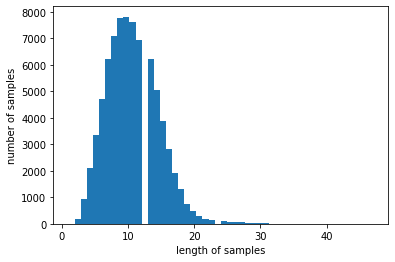

In [56]:
print('채팅의 최대 길이 :',max(len(review) for review in X_train))
print('채팅의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [57]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [58]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 98.66642822471451


In [59]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [60]:
X_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   56,  389,  449,   94,   31,  834,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  503,   95,
        1486,   54,   71,  331,  693,  305, 1149,  138,   66],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  745,
        1996, 1854,   45,   10,  715,  143, 1226,  107,   59],
       [   0,    0,    0,    0,    0, 1741,  112,   28,   23,   13,  897,
         572,  484,   91, 1487,    1, 1456,   17,    4,  317],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  677,
           1,  389,   40,  494,   94, 1429, 1240,  218,   22]],
      dtype=int32)

In [61]:
y_train[:5]

array([1, 0, 0, 1, 1])

In [62]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

78286
10199
78286
10199


# LSTM 을이용한 분류

In [63]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
974/979 [============================>.] - ETA: 0s - loss: 0.2493 - acc: 0.9062
Epoch 1: val_acc improved from -inf to 0.89922, saving model to best_model.h5
979/979 [==============================] - 16s 8ms/step - loss: 0.2493 - acc: 0.9061 - val_loss: 0.2664 - val_acc: 0.8992
Epoch 2/15
974/979 [============================>.] - ETA: 0s - loss: 0.2010 - acc: 0.9249
Epoch 2: val_acc improved from 0.89922 to 0.90133, saving model to best_model.h5
979/979 [==============================] - 7s 7ms/step - loss: 0.2009 - acc: 0.9250 - val_loss: 0.2576 - val_acc: 0.9013
Epoch 3/15
979/979 [==============================] - ETA: 0s - loss: 0.1879 - acc: 0.9299
Epoch 3: val_acc improved from 0.90133 to 0.90280, saving model to best_model.h5
979/979 [==============================] - 8s 8ms/step - loss: 0.1879 - acc: 0.9299 - val_loss: 0.2563 - val_acc: 0.9028
Epoch 4/15
972/979 [============================>.] - ETA: 0s - loss: 0.1794 - acc: 0.9333
Epoch 4: val_acc improved from 0

In [64]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

319/319 [==============================] - 2s 3ms/step - loss: 0.9818 - acc: 0.7449

 테스트 정확도: 0.7449


In [65]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 기쁨 입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 입니다.\n".format((1 - score) * 100))

In [66]:
sentiment_predict('정말 죽고싶어요.')

98.82% 확률로 부정 입니다.



In [67]:
sentiment_predict('오늘은 날씨가 정말 맑네요!')

90.64% 확률로 기쁨 입니다.



# 틀린 예측

In [68]:
sentiment_predict('오늘 날씨는 제 기분처럼 너무 흐려요')

73.02% 확률로 부정 입니다.



In [69]:
sentiment_predict('오늘 제 기분은 너무 흐리네요')

71.53% 확률로 기쁨 입니다.



# 1D CNN

In [70]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [71]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

In [72]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [73]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])


Epoch 1/10

Epoch 1: val_acc improved from -inf to 0.89756, saving model to CNN_model.h5
979/979 - 15s - loss: 0.2977 - acc: 0.8847 - val_loss: 0.2681 - val_acc: 0.8976 - 15s/epoch - 16ms/step
Epoch 2/10

Epoch 2: val_acc improved from 0.89756 to 0.90152, saving model to CNN_model.h5
979/979 - 7s - loss: 0.2071 - acc: 0.9225 - val_loss: 0.2579 - val_acc: 0.9015 - 7s/epoch - 7ms/step
Epoch 3/10

Epoch 3: val_acc did not improve from 0.90152
979/979 - 6s - loss: 0.1838 - acc: 0.9317 - val_loss: 0.2606 - val_acc: 0.8990 - 6s/epoch - 7ms/step
Epoch 4/10

Epoch 4: val_acc did not improve from 0.90152
979/979 - 6s - loss: 0.1671 - acc: 0.9386 - val_loss: 0.2669 - val_acc: 0.8990 - 6s/epoch - 6ms/step
Epoch 5/10

Epoch 5: val_acc did not improve from 0.90152
979/979 - 6s - loss: 0.1558 - acc: 0.9424 - val_loss: 0.2665 - val_acc: 0.8995 - 6s/epoch - 6ms/step
Epoch 6/10

Epoch 6: val_acc did not improve from 0.90152
979/979 - 6s - loss: 0.1456 - acc: 0.9460 - val_loss: 0.2770 - val_acc: 0.9005 

In [74]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

319/319 [==============================] - 1s 3ms/step - loss: 0.8883 - acc: 0.7466

 테스트 정확도: 0.7466


In [75]:
sentiment_predict('오늘은 날씨가 정말 맑네요!')

95.55% 확률로 기쁨 입니다.



In [76]:
sentiment_predict('정말 죽고싶어요.')

96.63% 확률로 부정 입니다.



In [77]:
sentiment_predict('오늘 날씨는 제 기분처럼 너무 흐려요')

93.29% 확률로 부정 입니다.



In [78]:
sentiment_predict('오늘은 무슨 큰일이라도 날거 같네요..')

97.49% 확률로 부정 입니다.



In [79]:
sentiment_predict('오늘 제 기분은 너무 흐리네요')

94.05% 확률로 부정 입니다.



# 틀린예측

## 원하는것 
- 사람문장 1이랑 사람문장 2가 곱해져서 좀더 높은 정확도를 분석할수있지않을까?

---

---

# 챗봇만들어보기 준비

-출처: https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/16.%20Transformer%20(Chatbot)/16-1%20~%2016-2.%20transformer_chatbot.ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 챗봇 만들기

In [ ]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
train_data1 = pd.read_excel('/content/감성대화말뭉치(최종데이터)_Training.xlsx')
train_data2 = pd.read_excel('/content/감성대화말뭉치(최종데이터)_Training.xlsx')
train_data1.drop(['번호','연령','성별','상황키워드','신체질환','사람문장2','사람문장3','사람문장4','시스템응답2','시스템응답3','시스템응답4'], axis=1, inplace=True)
train_data2.drop(['번호','연령','성별','상황키워드','신체질환','사람문장1','사람문장3','사람문장4','시스템응답1','시스템응답3','시스템응답4'], axis=1, inplace=True)
train_data2.rename(columns={'사람문장2':'사람문장1'},inplace=True)
train_data2.rename(columns={'시스템응답2': '시스템응답1'},inplace=True)
train_data2[:5]

In [ ]:
train_datases = pd.concat([train_data1, train_data2])
train_datases.reset_index(inplace=True)
train_datases['label'] = 0
for i in range(len(train_datases)):
  if train_datases['감정_대분류'][i] == '기쁨':
    train_datases['label'][i] = 1
  else:
    train_datases['label'][i] = 0

train_datases[-5:]

In [ ]:
test_data1 = pd.read_excel('/content/감성대화말뭉치(최종데이터)_Validation.xlsx')
test_data2 = pd.read_excel('/content/감성대화말뭉치(최종데이터)_Validation.xlsx')
test_data1.drop(['번호','연령','성별','상황키워드','신체질환','사람문장2','사람문장3','사람문장4','시스템응답2','시스템응답3','시스템응답4'], axis=1, inplace=True)
test_data2.drop(['번호','연령','성별','상황키워드','신체질환','사람문장1','사람문장3','사람문장4','시스템응답1','시스템응답3','시스템응답4'], axis=1, inplace=True)
test_data2.rename(columns={'사람문장2':'사람문장1'},inplace=True)
test_data2.rename(columns={'시스템응답2': '시스템응답1'},inplace=True)
test_data2[:5]

In [ ]:
test_datas = pd.concat([test_data1, test_data2])
test_datas.reset_index(inplace=True)
test_datas['label'] = 0
for i in range(len(test_datas)):
  if test_datas['감정_대분류'][i] == '기쁨':
    test_datas['label'][i] = 1
  else:
    test_datas['label'][i] = 0

test_datas[-5:]

In [ ]:
print('챗봇 샘플의 개수 :', len(train_datases))

In [ ]:
print(train_datases.isnull().sum())

In [ ]:
questions = []
for sentence in train_datases['사람문장1']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [ ]:
answers = []
for sentence in train_datases['시스템응답1']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [ ]:
len(questions)

In [ ]:
print(questions[:5])
print(answers[:5])

In [ ]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

In [ ]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)


In [ ]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

In [ ]:
pip install transformers

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
MAX_LENGTH = 40

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 15

model.fit(dataset, epochs=EPOCHS)

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence